In [88]:
%matplotlib widget
from spacer3d.utils import plot_process, plot_ripley, plot_individuals, plot_combined_univariate, plot_combined_multivariate

In [89]:
path = "./ripley_results/"

In [103]:
from glob import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def _calculate_p_values_two_tailed(observed_ripleyK, simulated_ripleyKs):
    """
    Calculate two-tailed p-values for Ripley's K function at each radius.

    Parameters:
    observed_ripleyK (array-like): An array of Ripley's K values calculated from the observed data for each radius.
    simulated_ripleyKs (array-like of array-like): A 2D array where each row represents the Ripley's K values 
                                                    from a single Monte Carlo simulation across the same radii as the observed data.

    Returns:
    np.array: An array of two-tailed p-values for each radius.
    """
    # Initialize an array to hold p-values for each radius
    p_values = np.zeros_like(observed_ripleyK, dtype=float)

    # Calculate p-value for each radius
    for i in range(len(observed_ripleyK)):
        # Count how many simulated Ripley's K values are more extreme than the observed value
        # For a two-tailed test, consider both tails
        # print((i, simulated_ripleyKs[:, i], observed_ripleyK[i]))
        lower_extreme_count = np.sum(simulated_ripleyKs[:, i] < observed_ripleyK[i])
        upper_extreme_count = np.sum(simulated_ripleyKs[:, i] >= observed_ripleyK[i])
        
        # For two-tailed, the extremeness is considered from both ends; thus, take the minimum count
        # and multiply by 2 to account for both tails
        extreme_count = min(lower_extreme_count, upper_extreme_count) * 2
        
        # Ensure the p-value does not exceed 1
        p_values[i] = np.minimum(extreme_count / simulated_ripleyKs.shape[0], 1.0)

    return p_values

def plot_p_values(rstats_path, save=False, output_folder="./ripley_results/"):
    def get_rstats_files(path):
        return glob(f"{path}/*.csv")

    def _plot(p_values, radii):
        # Combine into a DataFrame
        data = pd.DataFrame({
            "Radius": radii,
            "P-Value": p_values
        })
        plt.figure(figsize=(8, 6))  # Set the figure size for better visibility

        # Plot using seaborn
        sns.lineplot(data=data, x='Radius', y='P-Value', linestyle='-')

        # Draw a dotted horizontal line for the 0.05 threshold
        plt.axhline(y=0.05, color='red', linestyle='--', label='Significance Threshold (0.05)')

        # Flip the y-axis
        plt.ylim(1.0, 0)

        # Add labels and title for clarity
        plt.xlabel('Radius')
        plt.ylabel('P-Value')
        plt.title('P-Values vs. Radius with Significance Threshold')
        plt.legend()

        plt.show()
        
    rstats_files = get_rstats_files(rstats_path)
    print("Loaded:", rstats_files)

    # filter our monte carlo results
    rstats_files = [os.path.splitext(os.path.basename(f))[0] for f in rstats_files if "random" not in f]
    u_rstats_files = sorted([f for f in rstats_files if "univariate" in f])
    m_rstats_files = sorted([f for f in rstats_files if "multivariate" in f])

    types = ["tumor", "ng2", "branch", "tvc"]
    for t in types[:1]:
        t_files = [i for i in u_rstats_files if t in i]

        df = pd.DataFrame()
        df["Radius (r)"] = pd.Series(np.arange(2,100))
        for i, filename in enumerate(t_files):
            # Construct the path for the CSV file
            fullpath = os.path.join(rstats_path, f"{filename}.csv")
            prefix, _, date, id, mode, label, _ = filename.split("_")
            
            # Construct the path for the random CSV file
            rand_fullpath = os.path.join(rstats_path, f"FV10__{date}_{id}_random_{mode}_{label}_rstats.csv")
    
            # Load the CSV file and random CSV file into DataFrames
            rstats = pd.read_csv(fullpath)
            rand_rstats = pd.read_csv(rand_fullpath)

            # plot_ripley(rstats, rand_rstats)

            observed_ripleyK = rstats["K(r)"].to_numpy()

            # Determine the range of radii
            min_radius, max_radius = rstats["Radius (r)"].min(), rstats["Radius (r)"].max()
            expected_length = max_radius - min_radius + 1  # Adjust based on your radius range

            # Group by 'Line' and extract 'K(r)' values
            groups = rand_rstats.groupby('Line')['K(r)']

            simulated_arrays = []
            for name, group in groups:
                # Ensure the group has the expected length; you might need to handle cases where it doesn't
                assert len(group) == expected_length
                simulated_arrays.append(group.values)
            simulated_ripleyKs = np.array(simulated_arrays)

            p_values = _calculate_p_values_two_tailed(observed_ripleyK, simulated_ripleyKs)
            print(p_values.shape)
            _plot(p_values, np.arange(min_radius, max_radius+1))
            break

Loaded: ['./ripley_results/FV10__20181106_172421_univariate_branch_rstats.csv', './ripley_results/FV10__20181106_121902_univariate_tvc_rstats.csv', './ripley_results/FV10__20190619_111005_univariate_tumor_rstats.csv', './ripley_results/FV10__20190620_111343_random_multivariate_ng2_branch_rstats.csv', './ripley_results/FV10__20181008_104428_random_univariate_ng2_rstats.csv', './ripley_results/FV10__20190620_111343_random_multivariate_tumor_ng2_rstats.csv', './ripley_results/FV10__20181009_103052_random_multivariate_tumor_branch_rstats.csv', './ripley_results/FV10__20181008_104428_univariate_ng2_rstats.csv', './ripley_results/FV10__20181106_172421_random_multivariate_tumor_ng2_rstats.csv', './ripley_results/FV10__20190620_111343_multivariate_ng2_branch_rstats.csv', './ripley_results/FV10__20181009_103052_random_univariate_ng2_rstats.csv', './ripley_results/FV10__20181009_103052_univariate_tumor_rstats.csv', './ripley_results/FV10__20181004_122358_random_univariate_branch_rstats.csv', './

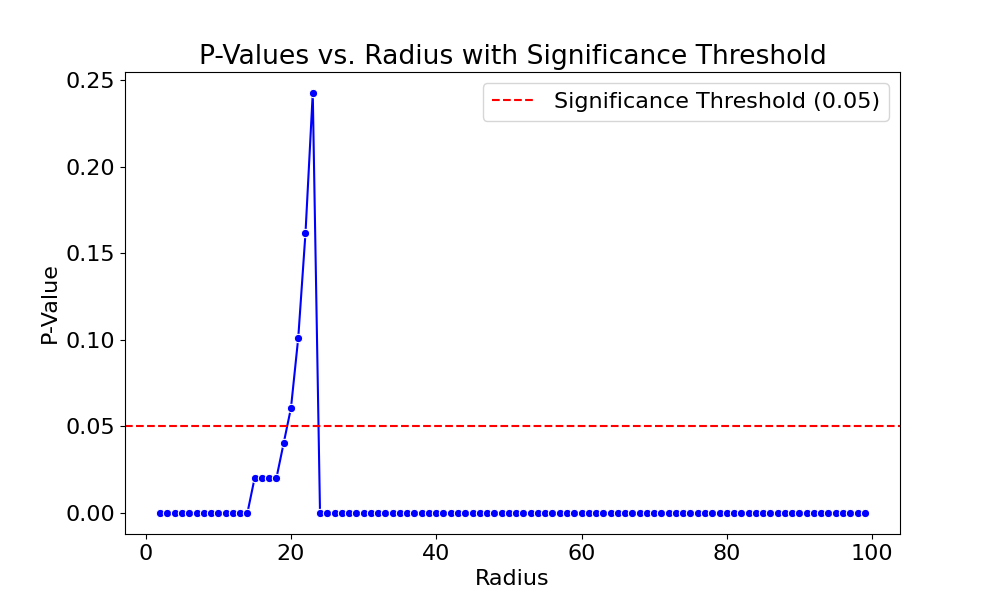

In [104]:
plot_p_values(path, save=False, output_folder="./ripley_results/")

In [ ]:
# Currently only supports univariate plots, will ignore multivariate rstats csv files
plot_process(path, save=False, output_folder="./ripley_results/")

In [ ]:
# Warning: This will work for BoneMets data currently, but it is not yet made for outside datasets
# Currently only supports univariate plots, will ignore multivariate rstats csv files
plot_individuals(path, save=False, output_folder="./ripley_results/")

In [ ]:
# Warning: This will work for BoneMets data currently, but it is not yet generalized for outside datasets
plot_combined_univariate(path)

In [ ]:
# Warning: This will work for BoneMets data currently, but it is not yet generalized for outside datasets
plot_combined_multivariate(path)